Using device: cpu
Loading MNIST dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Preparing data...
Train data shape: (10000, 784), Test data shape: (2000, 784)
Initializing model...
Training autoencoder...
Epoch [5/30], Loss: 0.0557
Epoch [10/30], Loss: 0.0402
Epoch [15/30], Loss: 0.0332
Epoch [20/30], Loss: 0.0301
Epoch [25/30], Loss: 0.0278
Epoch [30/30], Loss: 0.0260
Autoencoder training completed in 20.00 seconds!


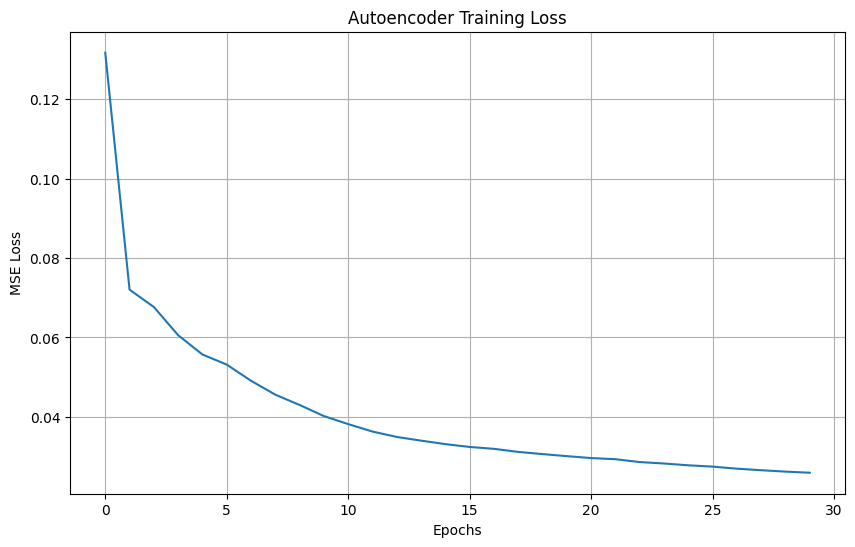

Extracting embeddings...
Train embeddings shape: (10000, 10)
Test embeddings shape: (2000, 10)

Evaluating clustering performance...
Running K-Means clustering...
Running DBSCAN clustering...

Evaluating clustering performance...
Running K-Means clustering...
Running DBSCAN clustering...

Train Set Metrics:
K-Means:
Silhouette: 0.1882
Davies Bouldin: 1.4276
Calinski Harabasz: 1751.9579

DBSCAN:
Silhouette: -0.5107
Davies Bouldin: 1.4172
Calinski Harabasz: 18.2549

Test Set Metrics:
K-Means:
Silhouette: 0.1865
Davies Bouldin: 1.5798
Calinski Harabasz: 355.2655

DBSCAN:
Silhouette: -0.0936
Davies Bouldin: 1.2077
Calinski Harabasz: 35.4393
Visualizing results...
Running t-SNE for visualization...


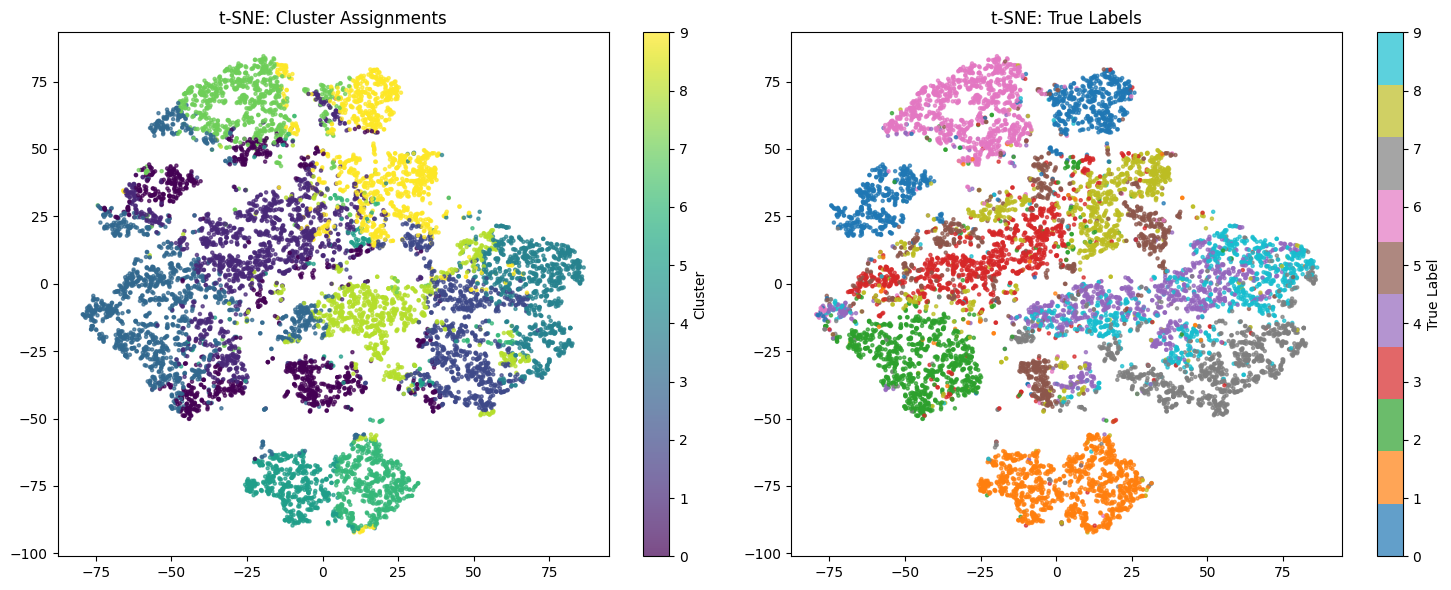

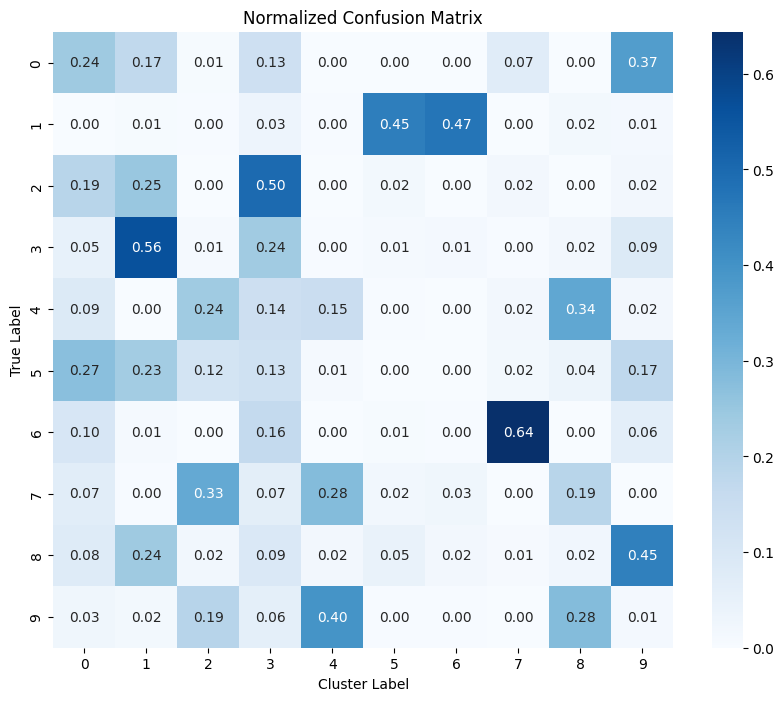

Running t-SNE for visualization...


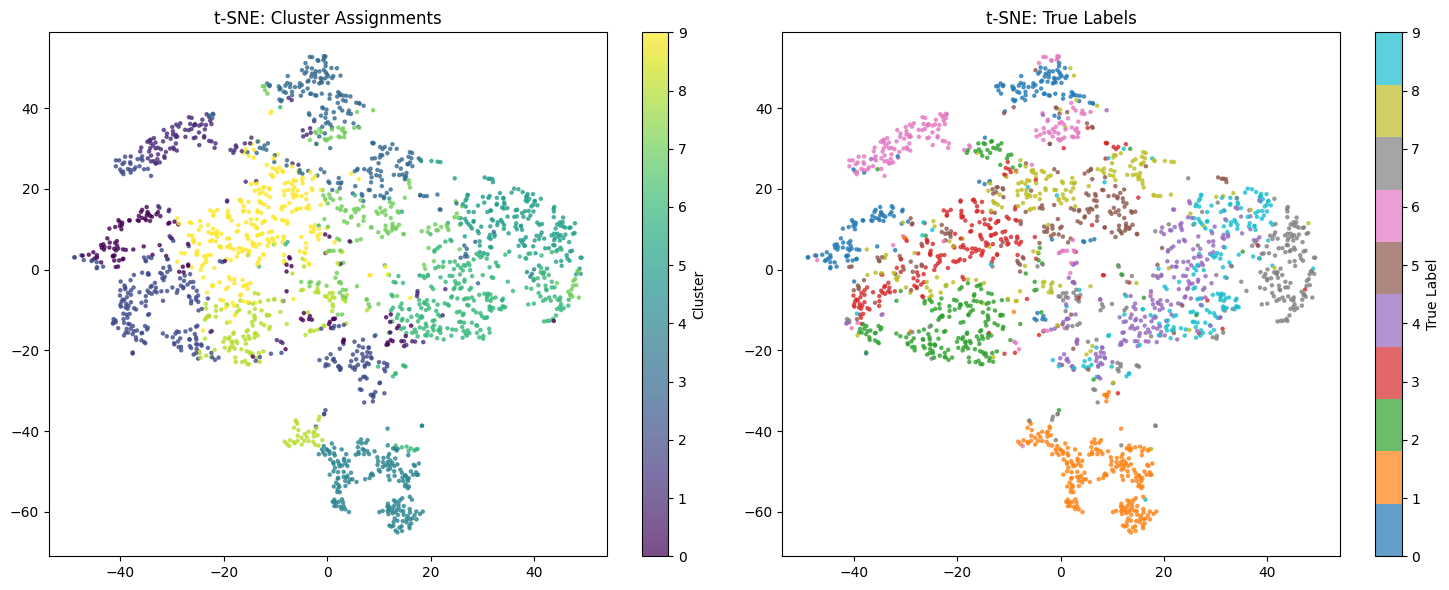

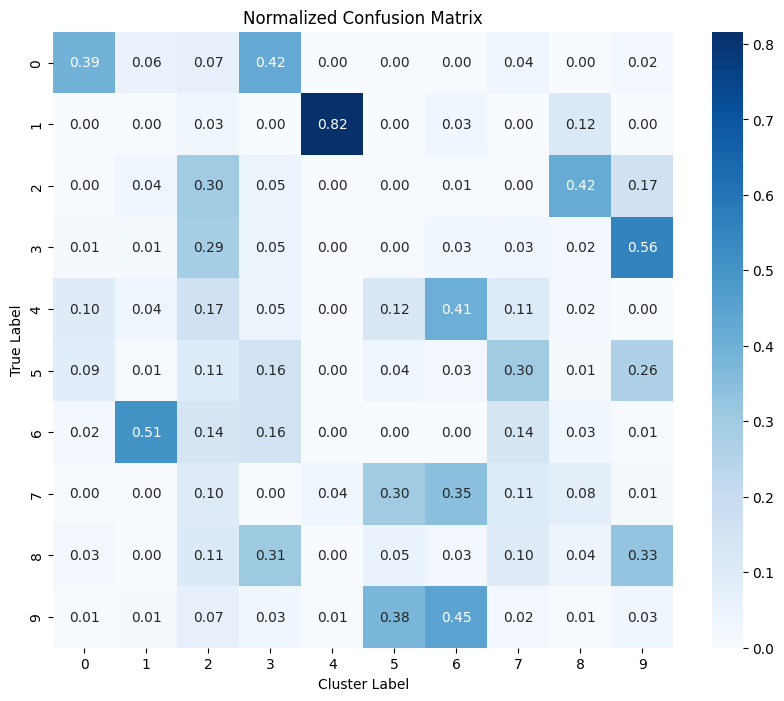

Running t-SNE for visualization...


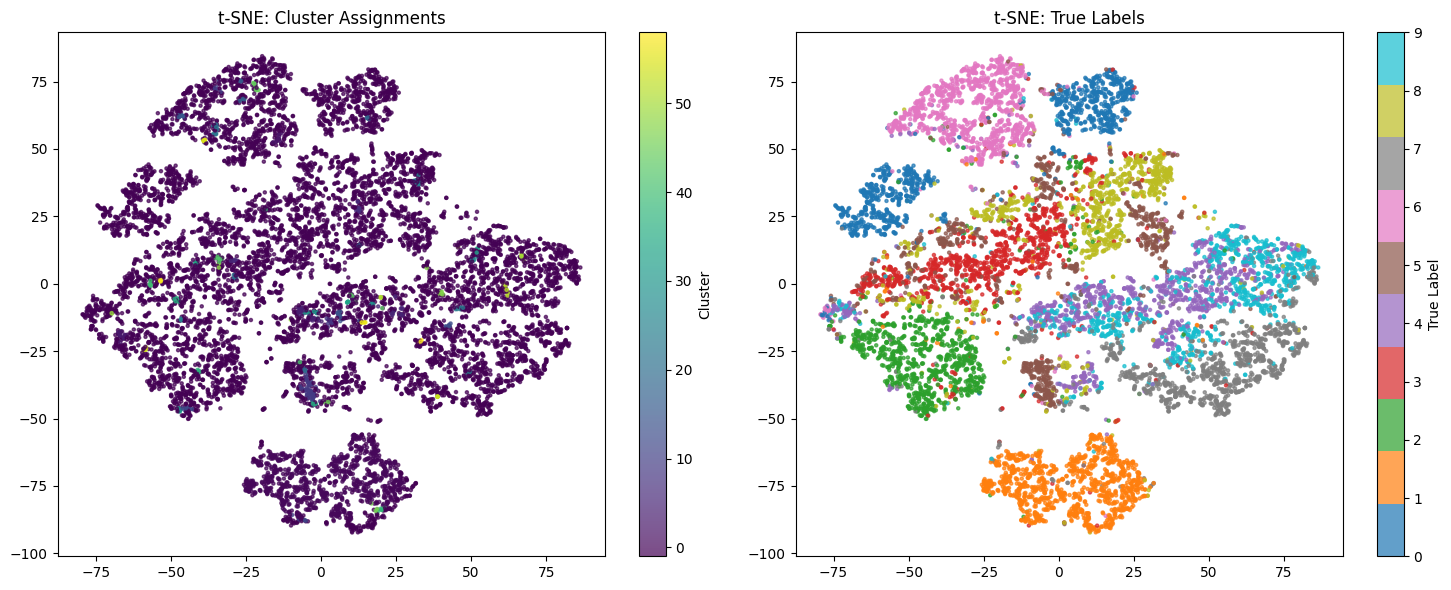

Running t-SNE for visualization...


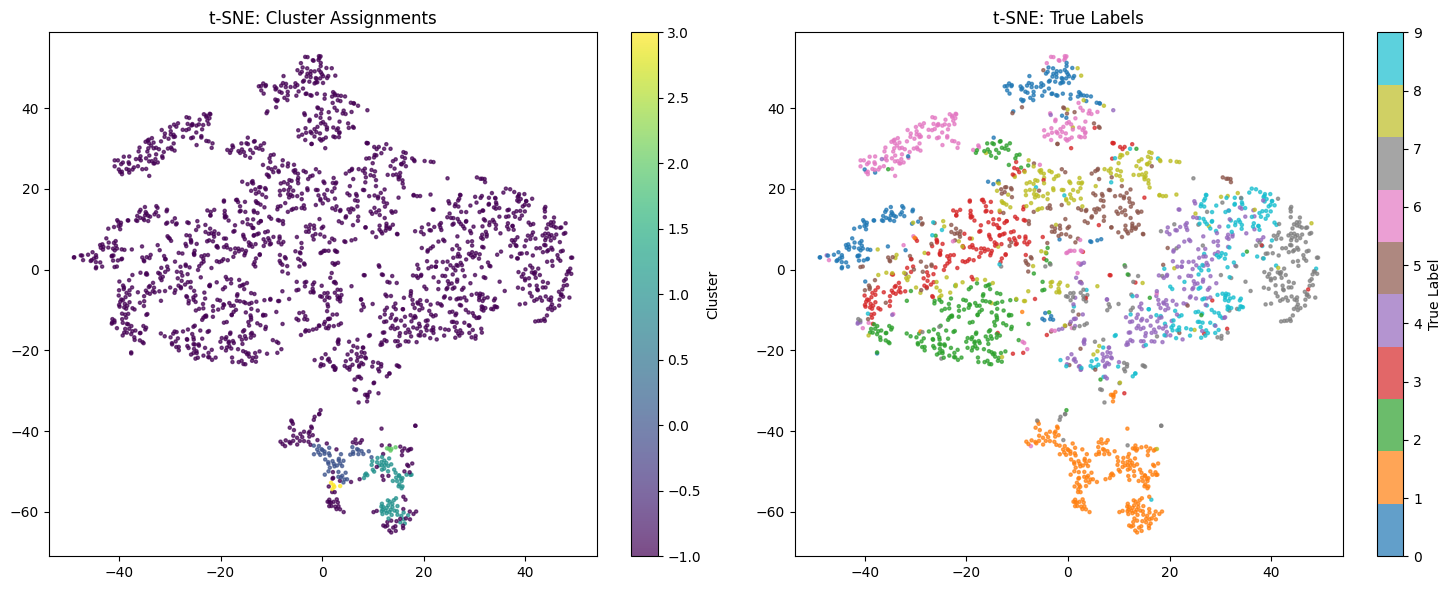

<ipython-input-1-35cd87fb734a>:288: RuntimeWarning: invalid value encountered in divide
  conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True)


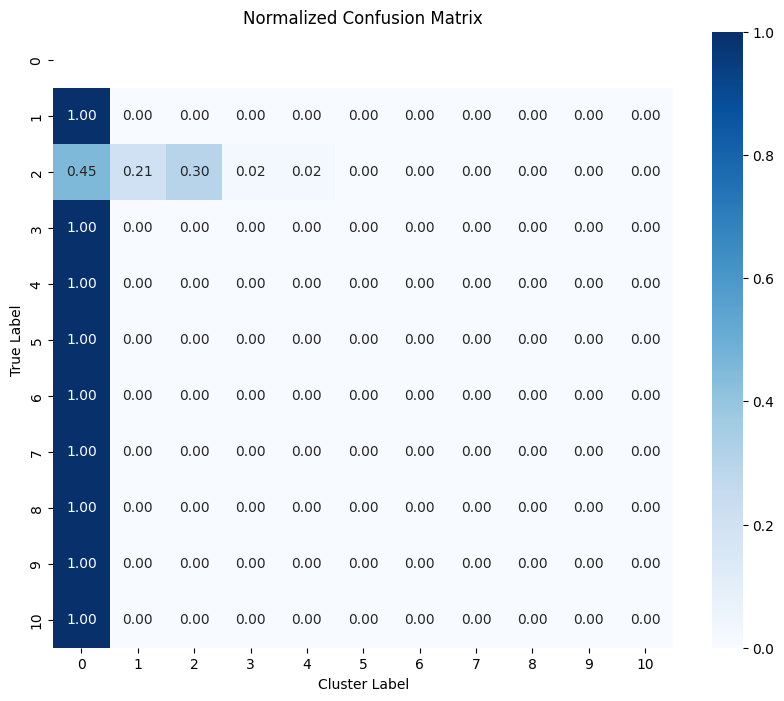

Saving model and results...
All done!


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from datasets import load_dataset
import seaborn as sns
from time import time
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MNIST dataset
print("Loading MNIST dataset...")
try:
    ds = load_dataset("mnist")
except:
    # Fallback to tensorflow if HuggingFace fails
    from tensorflow.keras.datasets import mnist
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    ds = {
        'train': {
            'image': [train_images[i] for i in range(len(train_images))],
            'label': train_labels
        },
        'test': {
            'image': [test_images[i] for i in range(len(test_images))],
            'label': test_labels
        }
    }

# Prepare data for training
def prepare_data(dataset, num_samples=10000, test_samples=2000):
    # Extract images and labels
    train_images = dataset['train']['image'][:num_samples]
    train_labels = dataset['train']['label'][:num_samples]
    test_images = dataset['test']['image'][:test_samples]
    test_labels = dataset['test']['label'][:test_samples]

    # Convert images to numpy arrays
    train_images_np = np.array([np.array(img) for img in train_images])
    test_images_np = np.array([np.array(img) for img in test_images])

    # Normalize and flatten images
    train_images_np = train_images_np.reshape(train_images_np.shape[0], -1) / 255.0
    test_images_np = test_images_np.reshape(test_images_np.shape[0], -1) / 255.0

    return train_images_np, np.array(train_labels), test_images_np, np.array(test_labels)

# Prepare data
print("Preparing data...")
train_images, train_labels, test_images, test_labels = prepare_data(ds)
print(f"Train data shape: {train_images.shape}, Test data shape: {test_images.shape}")

# Create DataLoaders
X_train = torch.FloatTensor(train_images)
y_train = torch.LongTensor(train_labels)
X_test = torch.FloatTensor(test_images)
y_test = torch.LongTensor(test_labels)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the Autoencoder model for Deep Embedding Clustering
class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, encoding_dim=128, latent_dim=10):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, encoding_dim // 2),
            nn.ReLU(),
            nn.Linear(encoding_dim // 2, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, encoding_dim // 2),
            nn.ReLU(),
            nn.Linear(encoding_dim // 2, encoding_dim),
            nn.ReLU(),
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1 for images
        )

    def forward(self, x):
        # Get the latent representation
        z = self.encoder(x)
        # Reconstruct input
        x_recon = self.decoder(z)
        return x_recon, z

    def encode(self, x):
        # Get the latent representation
        return self.encoder(x)

# Initialize model
print("Initializing model...")
input_dim = train_images.shape[1]  # 784 for MNIST
latent_dim = 10  # Dimension of latent space
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_autoencoder(model, train_loader, num_epochs=30):
    print("Training autoencoder...")
    losses = []
    start_time = time()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for data, _ in train_loader:
            # Move data to device
            data = data.to(device)

            # Forward pass
            recon, _ = model(data)
            loss = criterion(recon, data)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    training_time = time() - start_time
    print(f"Autoencoder training completed in {training_time:.2f} seconds!")
    return losses

# Train the autoencoder
losses = train_autoencoder(model, train_loader)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# Function to extract embeddings
def get_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            _, embedding = model(data)
            embeddings.append(embedding.cpu().numpy())
            labels.append(label.numpy())

    return np.vstack(embeddings), np.concatenate(labels)

# Extract embeddings
print("Extracting embeddings...")
train_embeddings, train_true_labels = get_embeddings(model, train_loader, device)
test_embeddings, test_true_labels = get_embeddings(model, test_loader, device)
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

# Cluster evaluation function
def evaluate_clustering(embeddings, true_labels, n_clusters=10):
    print("\nEvaluating clustering performance...")

    # K-Means clustering
    print("Running K-Means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(embeddings)

    # DBSCAN clustering
    print("Running DBSCAN clustering...")
    dbscan = DBSCAN(eps=3, min_samples=5)
    dbscan_labels = dbscan.fit_predict(embeddings)

    # Calculate metrics for K-Means
    kmeans_metrics = {
        'silhouette': silhouette_score(embeddings, kmeans_labels),
        'davies_bouldin': davies_bouldin_score(embeddings, kmeans_labels),
        'calinski_harabasz': calinski_harabasz_score(embeddings, kmeans_labels)
    }

    # Calculate metrics for DBSCAN (only if more than 1 cluster found)
    dbscan_metrics = {}
    if len(np.unique(dbscan_labels)) > 1:
        dbscan_metrics = {
            'silhouette': silhouette_score(embeddings, dbscan_labels),
            'davies_bouldin': davies_bouldin_score(embeddings, dbscan_labels),
            'calinski_harabasz': calinski_harabasz_score(embeddings, dbscan_labels)
        }

    # Calculate cluster to label mapping
    def calculate_mapping(cluster_labels, true_labels):
        mapping = defaultdict(list)
        for cluster, label in zip(cluster_labels, true_labels):
            mapping[cluster].append(label)
        return {k: np.bincount(v).argmax() for k, v in mapping.items()}

    kmeans_mapping = calculate_mapping(kmeans_labels, true_labels)

    return {
        'kmeans': {'labels': kmeans_labels, 'metrics': kmeans_metrics, 'mapping': kmeans_mapping},
        'dbscan': {'labels': dbscan_labels, 'metrics': dbscan_metrics}
    }

# Evaluate clustering on train and test sets
train_results = evaluate_clustering(train_embeddings, train_true_labels)
test_results = evaluate_clustering(test_embeddings, test_true_labels)

# Print metrics
def print_metrics(results, set_name):
    print(f"\n{set_name} Set Metrics:")
    print("K-Means:")
    for metric, value in results['kmeans']['metrics'].items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    if results['dbscan']['metrics']:
        print("\nDBSCAN:")
        for metric, value in results['dbscan']['metrics'].items():
            print(f"{metric.replace('_', ' ').title()}: {value:.4f}")
    else:
        print("\nDBSCAN: Only one cluster found")

print_metrics(train_results, "Train")
print_metrics(test_results, "Test")

# Visualization functions
def visualize_clusters(embeddings, cluster_labels, true_labels, filename_prefix):
    # Reduce dimensionality with t-SNE
    print("Running t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot clusters
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels,
                          cmap='viridis', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.title('t-SNE: Cluster Assignments')

    plt.subplot(1, 2, 2)
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=true_labels,
                          cmap='tab10', s=5, alpha=0.7)
    plt.colorbar(scatter, label='True Label')
    plt.title('t-SNE: True Labels')

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    if len(np.unique(cluster_labels)) <= 20:  # Only for reasonable number of clusters
        from sklearn.metrics import confusion_matrix
        conf_mat = confusion_matrix(true_labels, cluster_labels)
        conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_mat_norm, annot=True, fmt='.2f', cmap='Blues')
        plt.xlabel('Cluster Label')
        plt.ylabel('True Label')
        plt.title('Normalized Confusion Matrix')
        plt.show()

# Visualize results
print("Visualizing results...")
visualize_clusters(train_embeddings, train_results['kmeans']['labels'],
                  train_true_labels, 'train_kmeans')
visualize_clusters(test_embeddings, test_results['kmeans']['labels'],
                  test_true_labels, 'test_kmeans')

if len(np.unique(train_results['dbscan']['labels'])) > 1:
    visualize_clusters(train_embeddings, train_results['dbscan']['labels'],
                      train_true_labels, 'train_dbscan')
if len(np.unique(test_results['dbscan']['labels'])) > 1:
    visualize_clusters(test_embeddings, test_results['dbscan']['labels'],
                      test_true_labels, 'test_dbscan')

# Save the model and results
print("Saving model and results...")
torch.save(model.state_dict(), 'autoencoder_model.pth')
np.savez('clustering_results.npz',
         train_embeddings=train_embeddings,
         test_embeddings=test_embeddings,
         train_kmeans_labels=train_results['kmeans']['labels'],
         test_kmeans_labels=test_results['kmeans']['labels'],
         train_dbscan_labels=train_results['dbscan']['labels'],
         test_dbscan_labels=test_results['dbscan']['labels'],
         train_true_labels=train_true_labels,
         test_true_labels=test_true_labels)

print("All done!")